# Housing Price Prediction

In [1]:
#### Importing necessary libraries ####

# Importing numpy for numerical clculations
import numpy as np

# Importing pndas to work with dataframes
import pandas as pd

#Importing matplotlib for Data Visualization
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Importing warnings to ignore warnings
import warnings
warnings.filterwarnings(action='ignore')

# Importing ols for Anova
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [2]:
#Importing data
data = pd.read_csv('Raw_Housing_Prices.csv')
data.head()

,ID,Date House was Sold,Sale Price,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,Waterfront View,No of Times Visited,...,Overall Grade,Area of the House from Basement (in Sqft),Basement Area (in Sqft),Age of House (in Years),Renovated Year,Zipcode,Latitude,Longitude,Living Area after Renovation (in Sqft),Lot Area after Renovation (in Sqft)
0,7129300520,14 October 2017,221900.0,3,1.00,1180.0,5650.0,1.0,No,None,...,7,1180.0,0,63,0,98178.0,47.5112,-122.257,1340.0,5650
1,6414100192,14 December 2017,538000.0,3,2.25,2570.0,7242.0,2.0,No,None,...,7,2170.0,400,67,1991,98125.0,47.7210,-122.319,1690.0,7639
2,5631500400,15 February 2016,180000.0,2,1.00,770.0,10000.0,1.0,No,None,...,6,770.0,0,85,0,98028.0,47.7379,-122.233,2720.0,8062
3,2487200875,14 December 2017,604000.0,4,3.00,1960.0,5000.0,1.0,No,None,...,7,1050.0,910,53,0,98136.0,47.5208,-122.393,1360.0,5000
4,1954400510,15 February 2016,510000.0,3,2.00,1680.0,8080.0,1.0,No,None,...,8,1680.0,0,31,0,98074.0,47.6168,-122.045,1800.0,7503


In [3]:
# Descriptive statistics of the data
data['Sale Price'].describe()

count    2.160900e+04
mean     5.401984e+05
std      3.673890e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: Sale Price, dtype: float64

<AxesSubplot:ylabel='Frequency'>

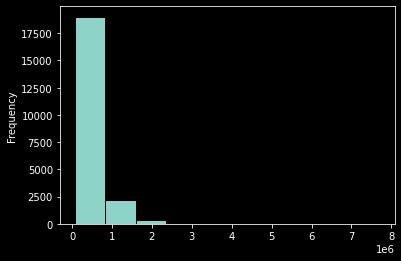

In [4]:
#distribution of target variable i.e Sale Price
data['Sale Price'].plot.hist(edgecolor="black")

In [5]:
# Checking quantiles
q1 = data['Sale Price'].quantile(0.25)
q3 = data['Sale Price'].quantile(0.75)
q1, q3

(321950.0, 645000.0)

In [6]:
#Calculating iqr (interquantile range)
iqr = q3 - q1
iqr

323050.0

In [7]:
# Noting down the upperBound and lower bound for treating the outliers
upper_limit = q3 + 1.5*iqr
lower_limit = q1 - 1.5*iqr
upper_limit, lower_limit

(1129575.0, -162625.0)

In [8]:
# Function to impute the outliers
def limit_imputer(value):
    if value > upper_limit:
        return upper_limit
    if value < lower_limit:
        return lower_limit
    else:
        return value

In [9]:
# Imputing outliers
data['Sale Price'] = data['Sale Price'].apply(limit_imputer)

In [10]:
# Descriptive statistics of  sale price now after treating the outliers
data['Sale Price'].describe()

count    2.160900e+04
mean     5.116186e+05
std      2.500620e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      1.129575e+06
Name: Sale Price, dtype: float64

<AxesSubplot:ylabel='Frequency'>

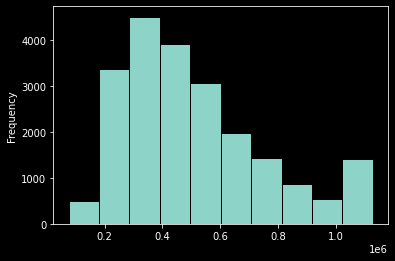

In [11]:
#After treating the outliers
data['Sale Price'].plot.hist(edgecolor='black')

In [12]:
#Checking for missing values
data.isnull().sum()

ID                                           0
Date House was Sold                          0
Sale Price                                   4
No of Bedrooms                               0
No of Bathrooms                              4
Flat Area (in Sqft)                          9
Lot Area (in Sqft)                           9
No of Floors                                 0
Waterfront View                              0
No of Times Visited                          0
Condition of the House                       0
Overall Grade                                0
Area of the House from Basement (in Sqft)    3
Basement Area (in Sqft)                      0
Age of House (in Years)                      0
Renovated Year                               0
Zipcode                                      1
Latitude                                     1
Longitude                                    1
Living Area after Renovation (in Sqft)       1
Lot Area after Renovation (in Sqft)          0
dtype: int64

In [13]:
# Dropping rows with null values
data['Sale Price'].dropna(inplace=True)
data['Sale Price'].isnull().sum()

4

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ID                                         21613 non-null  int64  
 1   Date House was Sold                        21613 non-null  object 
 2   Sale Price                                 21609 non-null  float64
 3   No of Bedrooms                             21613 non-null  int64  
 4   No of Bathrooms                            21609 non-null  float64
 5   Flat Area (in Sqft)                        21604 non-null  float64
 6   Lot Area (in Sqft)                         21604 non-null  float64
 7   No of Floors                               21613 non-null  float64
 8   Waterfront View                            21613 non-null  object 
 9   No of Times Visited                        21613 non-null  object 
 10  Condition of the House

### Imputing numerical missing values

In [15]:
#isolating numerical variables
numerical_columns = ['No of Bathrooms', 'Flat Area (in Sqft)','Lot Area (in Sqft)',
                     'Area of the House from Basement (in Sqft)','Latitude',
                     'Longitude','Living Area after Renovation (in Sqft)']

In [16]:
#imputing missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
data[numerical_columns] = imputer.fit_transform(data[numerical_columns])

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ID                                         21613 non-null  int64  
 1   Date House was Sold                        21613 non-null  object 
 2   Sale Price                                 21609 non-null  float64
 3   No of Bedrooms                             21613 non-null  int64  
 4   No of Bathrooms                            21613 non-null  float64
 5   Flat Area (in Sqft)                        21613 non-null  float64
 6   Lot Area (in Sqft)                         21613 non-null  float64
 7   No of Floors                               21613 non-null  float64
 8   Waterfront View                            21613 non-null  object 
 9   No of Times Visited                        21613 non-null  object 
 10  Condition of the House

# zipcode transform

In [18]:
# imputing missing values of zipcode
imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
data['Zipcode'] = imputer.fit_transform(data['Zipcode'].values.reshape(-1,1))

In [19]:
data['Zipcode'].shape

(21613,)

In [20]:
column = data["Zipcode"].values.reshape(-1,1)
column.shape

(21613, 1)

In [21]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
data['Zipcode'] = imputer.fit_transform(column)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ID                                         21613 non-null  int64  
 1   Date House was Sold                        21613 non-null  object 
 2   Sale Price                                 21609 non-null  float64
 3   No of Bedrooms                             21613 non-null  int64  
 4   No of Bathrooms                            21613 non-null  float64
 5   Flat Area (in Sqft)                        21613 non-null  float64
 6   Lot Area (in Sqft)                         21613 non-null  float64
 7   No of Floors                               21613 non-null  float64
 8   Waterfront View                            21613 non-null  object 
 9   No of Times Visited                        21613 non-null  object 
 10  Condition of the House

# Other transformations

In [23]:
# Unique values of No. of times visited
data['No of Times Visited'].unique()

array(['None', 'Thrice', 'Four', 'Twice', 'Once'], dtype=object)

In [24]:
# converting from string to categorical
mapping = {'None' : "0",
           'Once' : '1',
           'Twice' : '2',
           'Thrice' : '3',
           'Four' : '4'}

data['No of Times Visited'] = data['No of Times Visited'].map(mapping)

In [25]:
# after conversion
data['No of Times Visited'].unique()

array(['0', '3', '4', '2', '1'], dtype=object)

In [26]:
# new variable creation Ever Renovated to get info if the house was renovated or not
data['Ever Renovated'] = np.where(data['Renovated Year'] == 0, 'No', 'Yes')

In [27]:
data.head()

,ID,Date House was Sold,Sale Price,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,Waterfront View,No of Times Visited,...,Area of the House from Basement (in Sqft),Basement Area (in Sqft),Age of House (in Years),Renovated Year,Zipcode,Latitude,Longitude,Living Area after Renovation (in Sqft),Lot Area after Renovation (in Sqft),Ever Renovated
0,7129300520,14 October 2017,221900.0,3,1.00,1180.0,5650.0,1.0,No,0,...,1180.0,0,63,0,98178.0,47.5112,-122.257,1340.0,5650,No
1,6414100192,14 December 2017,538000.0,3,2.25,2570.0,7242.0,2.0,No,0,...,2170.0,400,67,1991,98125.0,47.7210,-122.319,1690.0,7639,Yes
2,5631500400,15 February 2016,180000.0,2,1.00,770.0,10000.0,1.0,No,0,...,770.0,0,85,0,98028.0,47.7379,-122.233,2720.0,8062,No
3,2487200875,14 December 2017,604000.0,4,3.00,1960.0,5000.0,1.0,No,0,...,1050.0,910,53,0,98136.0,47.5208,-122.393,1360.0,5000,No
4,1954400510,15 February 2016,510000.0,3,2.00,1680.0,8080.0,1.0,No,0,...,1680.0,0,31,0,98074.0,47.6168,-122.045,1800.0,7503,No


In [28]:
# Manipulating datetime variable
# new variable creation Purchase Year to get the year of purchase of the house
data['Purchase Year'] = pd.DatetimeIndex(data['Date House was Sold']).year

In [29]:
# new variable creation Years Since Renovation --> since how many years house hasn't been renovated before purchasing
# i.e purchase_year - renovated year  if renovated
data['Years Since Renovation'] = np.where(data['Ever Renovated'] == 'Yes',
                                                     abs(data['Purchase Year'] - 
                                                        data['Renovated Year']), 0)

In [30]:
data.head()

,ID,Date House was Sold,Sale Price,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,Waterfront View,No of Times Visited,...,Age of House (in Years),Renovated Year,Zipcode,Latitude,Longitude,Living Area after Renovation (in Sqft),Lot Area after Renovation (in Sqft),Ever Renovated,Purchase Year,Years Since Renovation
0,7129300520,14 October 2017,221900.0,3,1.00,1180.0,5650.0,1.0,No,0,...,63,0,98178.0,47.5112,-122.257,1340.0,5650,No,2017,0
1,6414100192,14 December 2017,538000.0,3,2.25,2570.0,7242.0,2.0,No,0,...,67,1991,98125.0,47.7210,-122.319,1690.0,7639,Yes,2017,26
2,5631500400,15 February 2016,180000.0,2,1.00,770.0,10000.0,1.0,No,0,...,85,0,98028.0,47.7379,-122.233,2720.0,8062,No,2016,0
3,2487200875,14 December 2017,604000.0,4,3.00,1960.0,5000.0,1.0,No,0,...,53,0,98136.0,47.5208,-122.393,1360.0,5000,No,2017,0
4,1954400510,15 February 2016,510000.0,3,2.00,1680.0,8080.0,1.0,No,0,...,31,0,98074.0,47.6168,-122.045,1800.0,7503,No,2016,0


In [31]:
# dropping redundant variables --> Purchase Year, Date House was Sold, Renovated Year are no longer in use
data.drop( columns = ['Purchase Year', 'Date House was Sold', 'Renovated Year'], inplace = True)

In [32]:
data.head()

,ID,Sale Price,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,Waterfront View,No of Times Visited,Condition of the House,...,Area of the House from Basement (in Sqft),Basement Area (in Sqft),Age of House (in Years),Zipcode,Latitude,Longitude,Living Area after Renovation (in Sqft),Lot Area after Renovation (in Sqft),Ever Renovated,Years Since Renovation
0,7129300520,221900.0,3,1.00,1180.0,5650.0,1.0,No,0,Fair,...,1180.0,0,63,98178.0,47.5112,-122.257,1340.0,5650,No,0
1,6414100192,538000.0,3,2.25,2570.0,7242.0,2.0,No,0,Fair,...,2170.0,400,67,98125.0,47.7210,-122.319,1690.0,7639,Yes,26
2,5631500400,180000.0,2,1.00,770.0,10000.0,1.0,No,0,Fair,...,770.0,0,85,98028.0,47.7379,-122.233,2720.0,8062,No,0
3,2487200875,604000.0,4,3.00,1960.0,5000.0,1.0,No,0,Excellent,...,1050.0,910,53,98136.0,47.5208,-122.393,1360.0,5000,No,0
4,1954400510,510000.0,3,2.00,1680.0,8080.0,1.0,No,0,Fair,...,1680.0,0,31,98074.0,47.6168,-122.045,1800.0,7503,No,0


In [33]:
# Dropping column ID since it's useless
data.drop( columns = 'ID', inplace = True)

In [34]:
data['Condition of the House'].head(10)

0         Fair
1         Fair
2         Fair
3    Excellent
4         Fair
5         Fair
6         Fair
7         Fair
8         Fair
9         Fair
Name: Condition of the House, dtype: object

In [35]:
# Values corresponding to each level of Condition of the House
data['Condition of the House'].value_counts()

Fair         14031
Good          5679
Excellent     1701
Okay           172
Bad             30
Name: Condition of the House, dtype: int64

<AxesSubplot:xlabel='Condition of the House'>

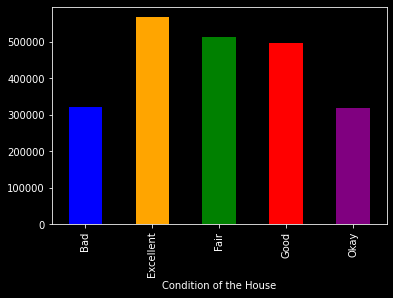

In [36]:
# Plotting bar graph of mean Sale Price wrt condition of the house
data.groupby('Condition of the House')['Sale Price'].mean().plot(kind = 'bar',color=['blue','orange','green','red','purple'])

<AxesSubplot:xlabel='Condition of the House'>

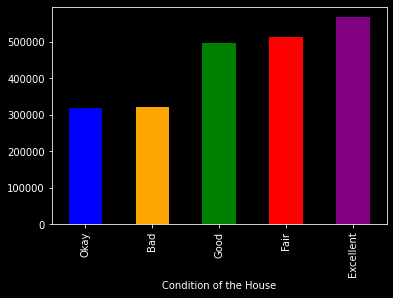

In [37]:
# arranging the bars in ascending order
data.groupby('Condition of the House')['Sale Price'].mean().sort_values().plot(kind = 'bar',color=['blue','orange','green','red','purple'])

<AxesSubplot:xlabel='Waterfront View'>

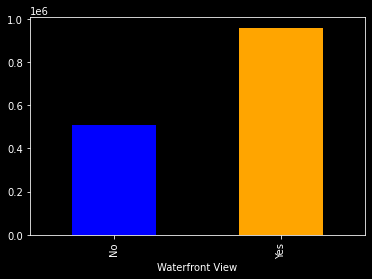

In [38]:
# Plotting bar graph of mean Sale Price wrt Waterfront View
# Shows houses with higher mean sale price have waterfront view
data.groupby('Waterfront View')['Sale Price'].mean().sort_values().plot(kind = 'bar',color=['blue','orange'])

<AxesSubplot:xlabel='Ever Renovated'>

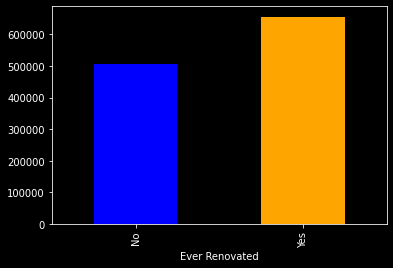

In [39]:
# Plotting bar graph of mean Sale Price wrt Ever Renovated
# Shows houses with higher mean sale price have been renovated
data.groupby('Ever Renovated')['Sale Price'].mean().sort_values().plot(kind = 'bar',color=['blue','orange'])

<AxesSubplot:xlabel='Zipcode'>

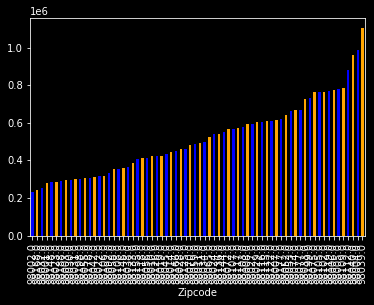

In [40]:
# Plotting bar graph of mean Sale Price wrt Zipcode
# we can also bin the zip code but doing that we're losing few datas
data.groupby('Zipcode',)['Sale Price'].mean().sort_values().plot(kind = 'bar',color=['blue','orange'])

### ANOVA (Analysis of variance)

In [41]:
# A method to find the relation between categorical and numerical target variable

#Renaming the variable names
data = data.rename(columns={'Sale Price':'Sale_Price'})
data = data.rename(columns={'Waterfront View':'Waterfront_View'})
data = data.rename(columns={'Ever Renovated':'Ever_Renovated'})
data = data.rename(columns={'Condition of the House':'Condition_of_the_House'})

In [42]:
data.head()

,Sale_Price,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,Waterfront_View,No of Times Visited,Condition_of_the_House,Overall Grade,Area of the House from Basement (in Sqft),Basement Area (in Sqft),Age of House (in Years),Zipcode,Latitude,Longitude,Living Area after Renovation (in Sqft),Lot Area after Renovation (in Sqft),Ever_Renovated,Years Since Renovation
0,221900.0,3,1.00,1180.0,5650.0,1.0,No,0,Fair,7,1180.0,0,63,98178.0,47.5112,-122.257,1340.0,5650,No,0
1,538000.0,3,2.25,2570.0,7242.0,2.0,No,0,Fair,7,2170.0,400,67,98125.0,47.7210,-122.319,1690.0,7639,Yes,26
2,180000.0,2,1.00,770.0,10000.0,1.0,No,0,Fair,6,770.0,0,85,98028.0,47.7379,-122.233,2720.0,8062,No,0
3,604000.0,4,3.00,1960.0,5000.0,1.0,No,0,Excellent,7,1050.0,910,53,98136.0,47.5208,-122.393,1360.0,5000,No,0
4,510000.0,3,2.00,1680.0,8080.0,1.0,No,0,Fair,8,1680.0,0,31,98074.0,47.6168,-122.045,1800.0,7503,No,0


In [43]:
# running anova for saleprice and condition of the house
mod= ols('Sale_Price ~ Condition_of_the_House',data = data).fit()
sm.stats.anova_lm(mod,typ=2)
#since p<0.05 therefore accept alternate hypothesis amd has an impact on the target variable so should be considered in model making


,sum_sq,df,F,PR(>F)
Condition_of_the_House,1.441831e+13,4.0,58.25563,5.447605e-49
Residual,1.336752e+15,21604.0,NaN,NaN


In [44]:
mod= ols('Sale_Price ~Waterfront_View',data =data).fit()
sm.stats.anova_lm(mod,typ=2)
# same for this

,sum_sq,df,F,PR(>F)
Waterfront_View,3.283737e+13,1.0,538.192683,1.275558e-117
Residual,1.318333e+15,21607.0,NaN,NaN


In [45]:
mod= ols('Sale_Price ~ Ever_Renovated',data = data).fit()
sm.stats.anova_lm(mod,typ=2)

,sum_sq,df,F,PR(>F)
Ever_Renovated,1.998463e+13,1.0,324.378469,5.419055e-72
Residual,1.331185e+15,21607.0,NaN,NaN


In [46]:
mod= ols('Sale_Price ~ Zipcode',data = data).fit()
sm.stats.anova_lm(mod,typ=2)

,sum_sq,df,F,PR(>F)
Zipcode,2.503765e+12,1.0,40.112844,2.444308e-10
Residual,1.348666e+15,21607.0,NaN,NaN


In [47]:
# Binning and Creation of Dummy Variables
data = pd.get_dummies(data,columns= ['Condition_of_the_House','Ever_Renovated','Waterfront_View'],drop_first=True)

In [48]:
data.head()

,Sale_Price,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,No of Times Visited,Overall Grade,Area of the House from Basement (in Sqft),Basement Area (in Sqft),...,Longitude,Living Area after Renovation (in Sqft),Lot Area after Renovation (in Sqft),Years Since Renovation,Condition_of_the_House_Excellent,Condition_of_the_House_Fair,Condition_of_the_House_Good,Condition_of_the_House_Okay,Ever_Renovated_Yes,Waterfront_View_Yes
0,221900.0,3,1.00,1180.0,5650.0,1.0,0,7,1180.0,0,...,-122.257,1340.0,5650,0,0,1,0,0,0,0
1,538000.0,3,2.25,2570.0,7242.0,2.0,0,7,2170.0,400,...,-122.319,1690.0,7639,26,0,1,0,0,1,0
2,180000.0,2,1.00,770.0,10000.0,1.0,0,6,770.0,0,...,-122.233,2720.0,8062,0,0,1,0,0,0,0
3,604000.0,4,3.00,1960.0,5000.0,1.0,0,7,1050.0,910,...,-122.393,1360.0,5000,0,1,0,0,0,0,0
4,510000.0,3,2.00,1680.0,8080.0,1.0,0,8,1680.0,0,...,-122.045,1800.0,7503,0,0,1,0,0,0,0


In [49]:
# Getting avg sale price accross each zipcode
Zip_Table = data.groupby('Zipcode').agg({'Sale_Price':'mean'}).sort_values('Sale_Price',ascending = True)

In [50]:
Zip_Table.head()

,Sale_Price
Zipcode,
98002.0,234284.035176
98168.0,240328.371747
98032.0,251296.240000
98001.0,280804.690608
98148.0,284908.596491


In [51]:
# Now we make 10 bins and categorize the 71 zipcodes in those 10 bins
Zip_Table['Zipcode_Group'] = pd.cut(Zip_Table['Sale_Price'],bins = 10,
                                   labels = ['Zipcode_Group_0',
                                            'Zipcode_Group_1',
                                             'Zipcode_Group_2',
                                            'Zipcode_Group_3',
                                            'Zipcode_Group_4',
                                            'Zipcode_Group_5',
                                            'Zipcode_Group_6',
                                            'Zipcode_Group_7',
                                            'Zipcode_Group_8',
                                            'Zipcode_Group_9'],
                                            include_lowest = True)

In [52]:
# dropping Sale price since we dont need it anymore]
Zip_Table = Zip_Table.drop(columns='Sale_Price')

In [53]:
 # Now we have to join this table with our original dataset
data = pd.merge(data,Zip_Table, left_on='Zipcode',how='left',right_index=True)

In [54]:
# Dropping zipcode as we placed Ziptable
data = data.drop(columns = 'Zipcode')

In [55]:
data.head()

,Sale_Price,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,No of Times Visited,Overall Grade,Area of the House from Basement (in Sqft),Basement Area (in Sqft),...,Living Area after Renovation (in Sqft),Lot Area after Renovation (in Sqft),Years Since Renovation,Condition_of_the_House_Excellent,Condition_of_the_House_Fair,Condition_of_the_House_Good,Condition_of_the_House_Okay,Ever_Renovated_Yes,Waterfront_View_Yes,Zipcode_Group
0,221900.0,3,1.00,1180.0,5650.0,1.0,0,7,1180.0,0,...,1340.0,5650,0,0,1,0,0,0,0,Zipcode_Group_0
1,538000.0,3,2.25,2570.0,7242.0,2.0,0,7,2170.0,400,...,1690.0,7639,26,0,1,0,0,1,0,Zipcode_Group_2
2,180000.0,2,1.00,770.0,10000.0,1.0,0,6,770.0,0,...,2720.0,8062,0,0,1,0,0,0,0,Zipcode_Group_2
3,604000.0,4,3.00,1960.0,5000.0,1.0,0,7,1050.0,910,...,1360.0,5000,0,1,0,0,0,0,0,Zipcode_Group_3
4,510000.0,3,2.00,1680.0,8080.0,1.0,0,8,1680.0,0,...,1800.0,7503,0,0,1,0,0,0,0,Zipcode_Group_4


In [56]:
# Now Create dummy variable for Zipcode_Group
data = pd.get_dummies(data,columns=['Zipcode_Group'],drop_first = True)

In [57]:
data.head()

,Sale_Price,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,No of Times Visited,Overall Grade,Area of the House from Basement (in Sqft),Basement Area (in Sqft),...,Waterfront_View_Yes,Zipcode_Group_Zipcode_Group_1,Zipcode_Group_Zipcode_Group_2,Zipcode_Group_Zipcode_Group_3,Zipcode_Group_Zipcode_Group_4,Zipcode_Group_Zipcode_Group_5,Zipcode_Group_Zipcode_Group_6,Zipcode_Group_Zipcode_Group_7,Zipcode_Group_Zipcode_Group_8,Zipcode_Group_Zipcode_Group_9
0,221900.0,3,1.00,1180.0,5650.0,1.0,0,7,1180.0,0,...,0,0,0,0,0,0,0,0,0,0
1,538000.0,3,2.25,2570.0,7242.0,2.0,0,7,2170.0,400,...,0,0,1,0,0,0,0,0,0,0
2,180000.0,2,1.00,770.0,10000.0,1.0,0,6,770.0,0,...,0,0,1,0,0,0,0,0,0,0
3,604000.0,4,3.00,1960.0,5000.0,1.0,0,7,1050.0,910,...,0,0,0,1,0,0,0,0,0,0
4,510000.0,3,2.00,1680.0,8080.0,1.0,0,8,1680.0,0,...,0,0,0,0,1,0,0,0,0,0


# Linear Regression


In [58]:
# Splitting data into independent and dependent variables
data.dropna(inplace=True)
X = data.drop(columns=['Sale_Price'])
Y = data['Sale_Price']

## variable transformation

In [59]:
#Fuction to check distribution of independent numerical variables
# by plotting each of them side by side
def distribution(data ,var):
    plt.figure(figsize = (len(var)*6,6), dpi = 120)
    for j,i in enumerate(var):
        plt.subplot(1,len(var),j+1)
        plt.hist(data[i],edgecolor='black')
        plt.title(i)

In [60]:
numerical_columns = ['No of Bedrooms', 'No of Bathrooms', 'Lot Area (in Sqft)',
       'No of Floors',
       'Area of the House from Basement (in Sqft)', 'Basement Area (in Sqft)',
       'Age of House (in Years)', 'Latitude', 'Longitude',
       'Living Area after Renovation (in Sqft)',
       'Lot Area after Renovation (in Sqft)',
       'Years Since Renovation']

In [61]:
for i in numerical_columns:
    X[i] = pd.to_numeric(X[i])

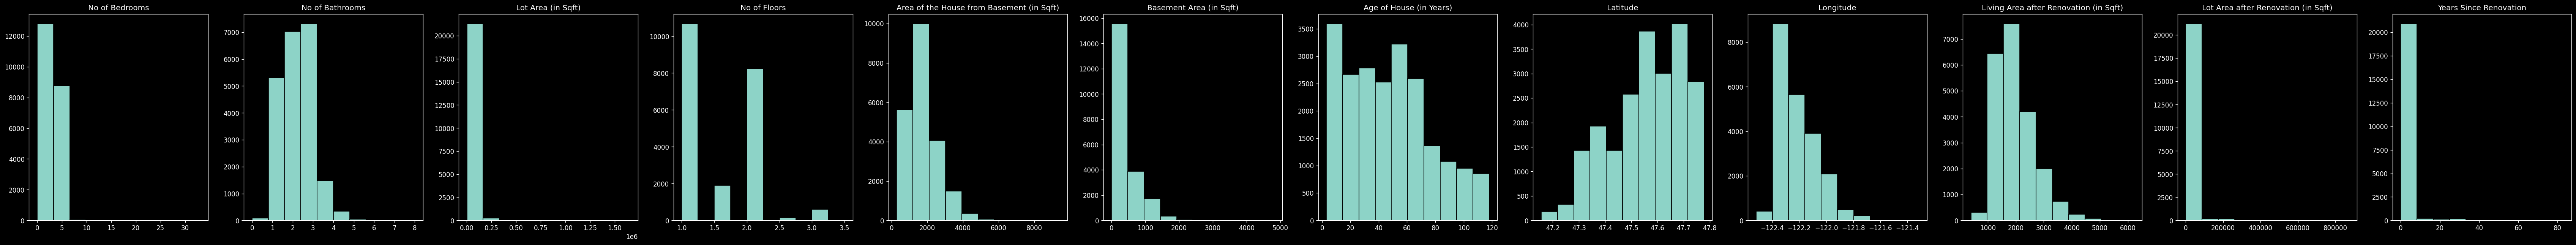

In [62]:
distribution(X, numerical_columns)

In [63]:
#removing right skew
# Function to remove right skewness using log transformation
def right_skew(x):
    return np.log(abs(x+500))


#Right skewed variables
right_skew_variables = ['No of Bedrooms', 'No of Bathrooms', 'Lot Area (in Sqft)',
       'No of Floors',
       'Area of the House from Basement (in Sqft)', 'Basement Area (in Sqft)',
        'Longitude',
       'Living Area after Renovation (in Sqft)',
       'Lot Area after Renovation (in Sqft)',
       'Years Since Renovation']

In [64]:
for i in right_skew_variables:
    X[i] = X[i].map(right_skew)

In [65]:
# removing infinite values
X = X.replace(np.inf, np.nan)
X.dropna(inplace=True)

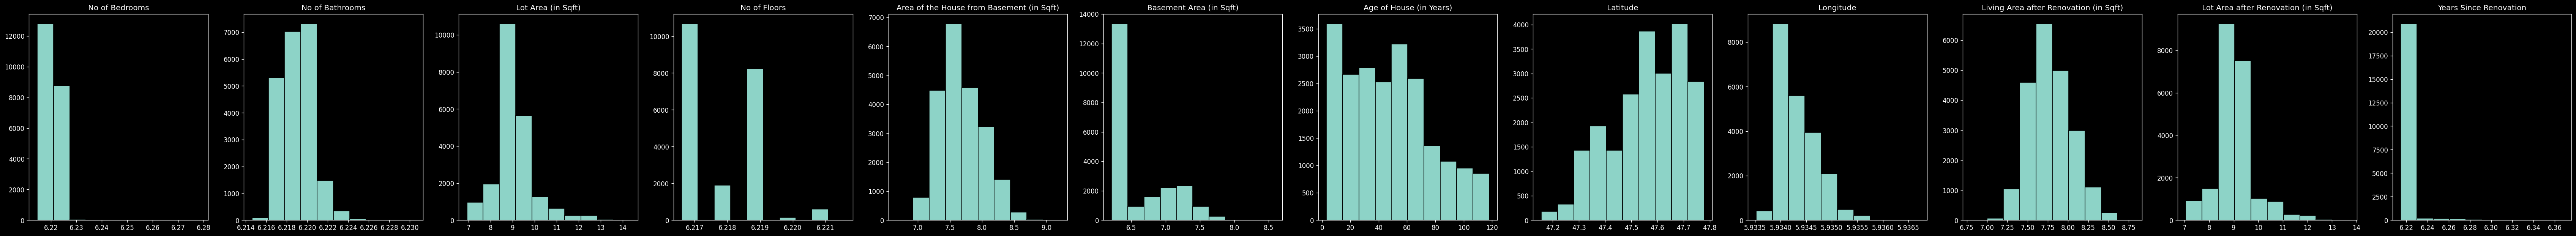

In [66]:
distribution(X, numerical_columns)

## Scaling the dataset

In [67]:
X.head()

,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,No of Times Visited,Overall Grade,Area of the House from Basement (in Sqft),Basement Area (in Sqft),Age of House (in Years),...,Waterfront_View_Yes,Zipcode_Group_Zipcode_Group_1,Zipcode_Group_Zipcode_Group_2,Zipcode_Group_Zipcode_Group_3,Zipcode_Group_Zipcode_Group_4,Zipcode_Group_Zipcode_Group_5,Zipcode_Group_Zipcode_Group_6,Zipcode_Group_Zipcode_Group_7,Zipcode_Group_Zipcode_Group_8,Zipcode_Group_Zipcode_Group_9
0,6.220590,6.216606,1180.0,8.724207,6.216606,0,7,7.426549,6.214608,63,...,0,0,0,0,0,0,0,0,0,0
1,6.220590,6.219098,2570.0,8.954415,6.218600,0,7,7.889834,6.802395,67,...,0,0,1,0,0,0,0,0,0,0
2,6.218600,6.216606,770.0,9.259131,6.216606,0,6,7.146772,6.214608,85,...,0,0,1,0,0,0,0,0,0,0
3,6.222576,6.220590,1960.0,8.612503,6.216606,0,7,7.346010,7.251345,53,...,0,0,0,1,0,0,0,0,0,0
4,6.220590,6.218600,1680.0,9.057189,6.216606,0,8,7.687080,6.214608,31,...,0,0,0,0,1,0,0,0,0,0


In [68]:
# Scaling the dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Y = data['Sale_Price']
X1 = scaler.fit_transform(X)
X = pd.DataFrame(data = X1, columns = X.columns)
X.head()

,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,No of Times Visited,Overall Grade,Area of the House from Basement (in Sqft),Basement Area (in Sqft),Age of House (in Years),...,Waterfront_View_Yes,Zipcode_Group_Zipcode_Group_1,Zipcode_Group_Zipcode_Group_2,Zipcode_Group_Zipcode_Group_3,Zipcode_Group_Zipcode_Group_4,Zipcode_Group_Zipcode_Group_5,Zipcode_Group_Zipcode_Group_6,Zipcode_Group_Zipcode_Group_7,Zipcode_Group_Zipcode_Group_8,Zipcode_Group_Zipcode_Group_9
0,-0.398647,-1.448931,-0.979905,-0.412101,-0.915604,-0.30579,-0.563993,-0.767588,-0.726332,0.544734,...,-0.087181,-0.350481,-0.482158,-0.419600,-0.479094,-0.214086,-0.287712,-0.112274,-0.16885,-0.048158
1,-0.398647,0.176496,0.533718,-0.139474,0.937193,-0.30579,-0.563993,0.642025,0.538457,0.680915,...,-0.087181,-0.350481,2.074011,-0.419600,-0.479094,-0.214086,-0.287712,-0.112274,-0.16885,-0.048158
2,-1.477788,-1.448931,-1.426369,0.221390,-0.915604,-0.30579,-1.468566,-1.618851,-0.726332,1.293731,...,-0.087181,-0.350481,2.074011,-0.419600,-0.479094,-0.214086,-0.287712,-0.112274,-0.16885,-0.048158
3,0.678352,1.149811,-0.130534,-0.544388,-0.915604,-0.30579,-0.563993,-1.012639,1.504500,0.204281,...,-0.087181,-0.350481,-0.482158,2.383223,-0.479094,-0.214086,-0.287712,-0.112274,-0.16885,-0.048158
4,-0.398647,-0.148266,-0.435436,-0.017762,-0.915604,-0.30579,0.340581,0.025117,-0.726332,-0.544715,...,-0.087181,-0.350481,-0.482158,-0.419600,2.087275,-0.214086,-0.287712,-0.112274,-0.16885,-0.048158


## Checking and Removing Multicollinearity

In [69]:
# Checking correlation
X.corr()

,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,No of Times Visited,Overall Grade,Area of the House from Basement (in Sqft),Basement Area (in Sqft),Age of House (in Years),...,Waterfront_View_Yes,Zipcode_Group_Zipcode_Group_1,Zipcode_Group_Zipcode_Group_2,Zipcode_Group_Zipcode_Group_3,Zipcode_Group_Zipcode_Group_4,Zipcode_Group_Zipcode_Group_5,Zipcode_Group_Zipcode_Group_6,Zipcode_Group_Zipcode_Group_7,Zipcode_Group_Zipcode_Group_8,Zipcode_Group_Zipcode_Group_9
No of Bedrooms,1.000000,0.516645,0.577469,0.175425,0.175995,0.079649,0.349933,0.509475,0.276781,-0.154613,...,-0.006617,-0.010565,-0.039396,-0.074396,0.024514,0.019485,0.090274,0.016703,0.102859,0.035737
No of Bathrooms,0.516645,1.000000,0.754415,0.105010,0.500980,0.187657,0.635778,0.696041,0.254042,-0.506206,...,0.063683,-0.032762,-0.081490,-0.034477,0.084113,0.052795,0.123241,0.037718,0.109942,0.067747
Flat Area (in Sqft),0.577469,0.754415,1.000000,0.341571,0.354268,0.284678,0.705725,0.853690,0.373296,-0.318146,...,0.103841,-0.058817,-0.063005,-0.078761,0.086139,0.075978,0.160045,0.051211,0.169576,0.090253
Lot Area (in Sqft),0.175425,0.105010,0.341571,1.000000,-0.218404,0.121698,0.165807,0.319715,0.056278,-0.006100,...,0.074316,0.024149,0.085244,-0.183542,-0.027076,0.046547,-0.011813,-0.078477,0.075148,0.037108
No of Floors,0.175995,0.500980,0.354268,-0.218404,1.000000,0.029503,0.461442,0.548408,-0.266598,-0.489232,...,0.023721,-0.003375,-0.067900,0.079146,0.071809,0.009219,0.069868,0.064986,-0.008630,0.005873
No of Times Visited,0.079649,0.187657,0.284678,0.121698,0.029503,1.000000,0.223661,0.161106,0.249446,0.053395,...,0.401856,-0.065000,0.004754,0.005905,0.003509,0.024801,0.068144,-0.012548,0.065335,0.012923
Overall Grade,0.349933,0.635778,0.705725,0.165807,0.461442,0.223661,1.000000,0.723789,0.116078,-0.456711,...,0.070332,-0.075495,-0.121379,-0.047869,0.151245,0.095613,0.200548,0.077126,0.156952,0.048638
Area of the House from Basement (in Sqft),0.509475,0.696041,0.853690,0.319715,0.548408,0.161106,0.723789,1.000000,-0.111289,-0.448692,...,0.063294,-0.019673,-0.055546,-0.097772,0.092118,0.058634,0.125459,0.029945,0.127926,0.069765
Basement Area (in Sqft),0.276781,0.254042,0.373296,0.056278,-0.266598,0.249446,0.116078,-0.111289,1.000000,0.153930,...,0.063276,-0.071126,-0.032765,0.019481,0.017343,0.040560,0.084122,0.057062,0.081651,0.016459
Age of House (in Years),-0.154613,-0.506206,-0.318146,-0.006100,-0.489232,0.053395,-0.456711,-0.448692,0.153930,1.000000,...,0.026149,-0.070111,0.022094,0.095882,-0.056974,-0.009965,0.025718,0.101486,-0.002705,-0.002492


In [70]:
## pair of independent variables with correlation greater than 0.5
## i!=j since we know a variable with itself has a correlation 1
k = X.corr()
z = [[str(i),str(j)] for i in k.columns for j in k.columns if (k.loc[i,j] >abs(0.5))&(i!=j)]
z, len(z)

([['No of Bedrooms', 'No of Bathrooms'],
  ['No of Bedrooms', 'Flat Area (in Sqft)'],
  ['No of Bedrooms', 'Area of the House from Basement (in Sqft)'],
  ['No of Bathrooms', 'No of Bedrooms'],
  ['No of Bathrooms', 'Flat Area (in Sqft)'],
  ['No of Bathrooms', 'No of Floors'],
  ['No of Bathrooms', 'Overall Grade'],
  ['No of Bathrooms', 'Area of the House from Basement (in Sqft)'],
  ['No of Bathrooms', 'Living Area after Renovation (in Sqft)'],
  ['Flat Area (in Sqft)', 'No of Bedrooms'],
  ['Flat Area (in Sqft)', 'No of Bathrooms'],
  ['Flat Area (in Sqft)', 'Overall Grade'],
  ['Flat Area (in Sqft)', 'Area of the House from Basement (in Sqft)'],
  ['Flat Area (in Sqft)', 'Living Area after Renovation (in Sqft)'],
  ['Lot Area (in Sqft)', 'Lot Area after Renovation (in Sqft)'],
  ['No of Floors', 'No of Bathrooms'],
  ['No of Floors', 'Area of the House from Basement (in Sqft)'],
  ['Overall Grade', 'No of Bathrooms'],
  ['Overall Grade', 'Flat Area (in Sqft)'],
  ['Overall Grade',

### Calculating VIF

In [71]:
# Importing Variance_inflation_Factor funtion from the Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = X[:]

## Calculating VIF for every column
VIF = pd.Series([variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])], index = vif_data.columns)
VIF

No of Bedrooms                                 1.744062
No of Bathrooms                                3.446568
Flat Area (in Sqft)                           21.798445
Lot Area (in Sqft)                             6.905227
No of Floors                                   2.441989
No of Times Visited                            1.417032
Overall Grade                                  3.113877
Area of the House from Basement (in Sqft)     23.584976
Basement Area (in Sqft)                        6.641002
Age of House (in Years)                        2.661722
Latitude                                       2.467248
Longitude                                      1.815369
Living Area after Renovation (in Sqft)         3.001087
Lot Area after Renovation (in Sqft)            6.650825
Years Since Renovation                         2.876512
Condition_of_the_House_Excellent              53.713670
Condition_of_the_House_Fair                  166.473114
Condition_of_the_House_Good                  141

In [72]:
VIF[VIF == VIF.max()].index[0]

'Condition_of_the_House_Fair'

In [73]:
#Function to remove multicollinearity
def MC_remover(data):
  vif = pd.Series([variance_inflation_factor(data.values, i) for i in range(data.shape[1])], index = data.columns)
  if vif.max() > 5:
    print(vif[vif == vif.max()].index[0],'has been removed')
    data = data.drop(columns = [vif[vif == vif.max()].index[0]])
    return data
  else:
    print('No Multicollinearity present anymore')
    return data

In [74]:
for i in range(7):
  vif_data = MC_remover(vif_data)

vif_data.head()

Condition_of_the_House_Fair has been removed
Area of the House from Basement (in Sqft) has been removed
Lot Area (in Sqft) has been removed
Flat Area (in Sqft) has been removed
No Multicollinearity present anymore
No Multicollinearity present anymore
No Multicollinearity present anymore


,No of Bedrooms,No of Bathrooms,No of Floors,No of Times Visited,Overall Grade,Basement Area (in Sqft),Age of House (in Years),Latitude,Longitude,Living Area after Renovation (in Sqft),...,Waterfront_View_Yes,Zipcode_Group_Zipcode_Group_1,Zipcode_Group_Zipcode_Group_2,Zipcode_Group_Zipcode_Group_3,Zipcode_Group_Zipcode_Group_4,Zipcode_Group_Zipcode_Group_5,Zipcode_Group_Zipcode_Group_6,Zipcode_Group_Zipcode_Group_7,Zipcode_Group_Zipcode_Group_8,Zipcode_Group_Zipcode_Group_9
0,-0.398647,-1.448931,-0.915604,-0.30579,-0.563993,-0.726332,0.544734,-0.352576,-0.306108,-1.027547,...,-0.087181,-0.350481,-0.482158,-0.419600,-0.479094,-0.214086,-0.287712,-0.112274,-0.16885,-0.048158
1,-0.398647,0.176496,0.937193,-0.30579,-0.563993,0.538457,0.680915,1.161645,-0.746519,-0.355983,...,-0.087181,-0.350481,2.074011,-0.419600,-0.479094,-0.214086,-0.287712,-0.112274,-0.16885,-0.048158
2,-1.477788,-1.448931,-0.915604,-0.30579,-1.468566,-0.726332,1.293731,1.283619,-0.135646,1.130637,...,-0.087181,-0.350481,2.074011,-0.419600,-0.479094,-0.214086,-0.287712,-0.112274,-0.16885,-0.048158
3,0.678352,1.149811,-0.915604,-0.30579,-0.563993,1.504500,0.204281,-0.283288,-1.272266,-0.985854,...,-0.087181,-0.350481,-0.482158,2.383223,-0.479094,-0.214086,-0.287712,-0.112274,-0.16885,-0.048158
4,-0.398647,-0.148266,-0.915604,-0.30579,0.340581,-0.726332,-0.544715,0.409587,1.199268,-0.166983,...,-0.087181,-0.350481,-0.482158,-0.419600,2.087275,-0.214086,-0.287712,-0.112274,-0.16885,-0.048158


### Remaining Columns

In [75]:
# Calculating VIF for remaining columns
VIF = pd.Series([variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])], index = vif_data.columns)
VIF, len(vif_data.columns)

(No of Bedrooms                            1.510710
 No of Bathrooms                           2.972530
 No of Floors                              2.230555
 No of Times Visited                       1.411379
 Overall Grade                             2.700371
 Basement Area (in Sqft)                   1.649707
 Age of House (in Years)                   2.574964
 Latitude                                  2.465853
 Longitude                                 1.776715
 Living Area after Renovation (in Sqft)    2.569633
 Lot Area after Renovation (in Sqft)       1.657713
 Years Since Renovation                    2.873450
 Condition_of_the_House_Excellent          1.204985
 Condition_of_the_House_Good               1.258980
 Condition_of_the_House_Okay               1.025202
 Ever_Renovated_Yes                        3.039216
 Waterfront_View_Yes                       1.210919
 Zipcode_Group_Zipcode_Group_1             1.538462
 Zipcode_Group_Zipcode_Group_2             2.566274
 Zipcode_Gro

## Train/Test set

In [76]:
X = vif_data[:]

In [77]:
Y = data['Sale_Price']

In [78]:
# Splitting up data to train and test dataset

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 101)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((15126, 26), (6483, 26), (15126,), (6483,))

## Training model

In [79]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize = True)
lr.fit(x_train, y_train)

LinearRegression(normalize=True)

In [80]:
#All coeff of the independent variables
lr.coef_

array([  7900.29414233,  38206.05402299,  17337.27280817,  29461.57681417,
        82149.28110478,   6567.11913179,  38720.41151826,  21569.24274556,
       -18677.50903406,  37442.98092902,  17370.55291716,  -8566.99320749,
        12412.5161508 ,   2912.67925499,  -2150.61567782,  12439.32502147,
        10941.00372942,  11220.12779435,  33245.63906713,  60797.08122337,
        77818.13457527,  49191.47401291,  70396.8091619 ,  38851.11311613,
        67898.7230312 ,  23444.96766541])

In [81]:
# generating Predictions and evaluation over the set 
predictions = lr.predict(x_test)

In [82]:
# Calculates the r2 value of the model
lr.score(x_test, y_test)

0.8222614330217801

### 1. Residuals

In [83]:
residuals = predictions - y_test

residual_table = pd.DataFrame({'residuals':residuals,
                    'predictions':predictions})

residual_table = residual_table.sort_values( by = 'predictions')

In [84]:
z = [i for i in range(int(residual_table['predictions'].max()))]
k = [0 for i in range(int(residual_table['predictions'].max()))]

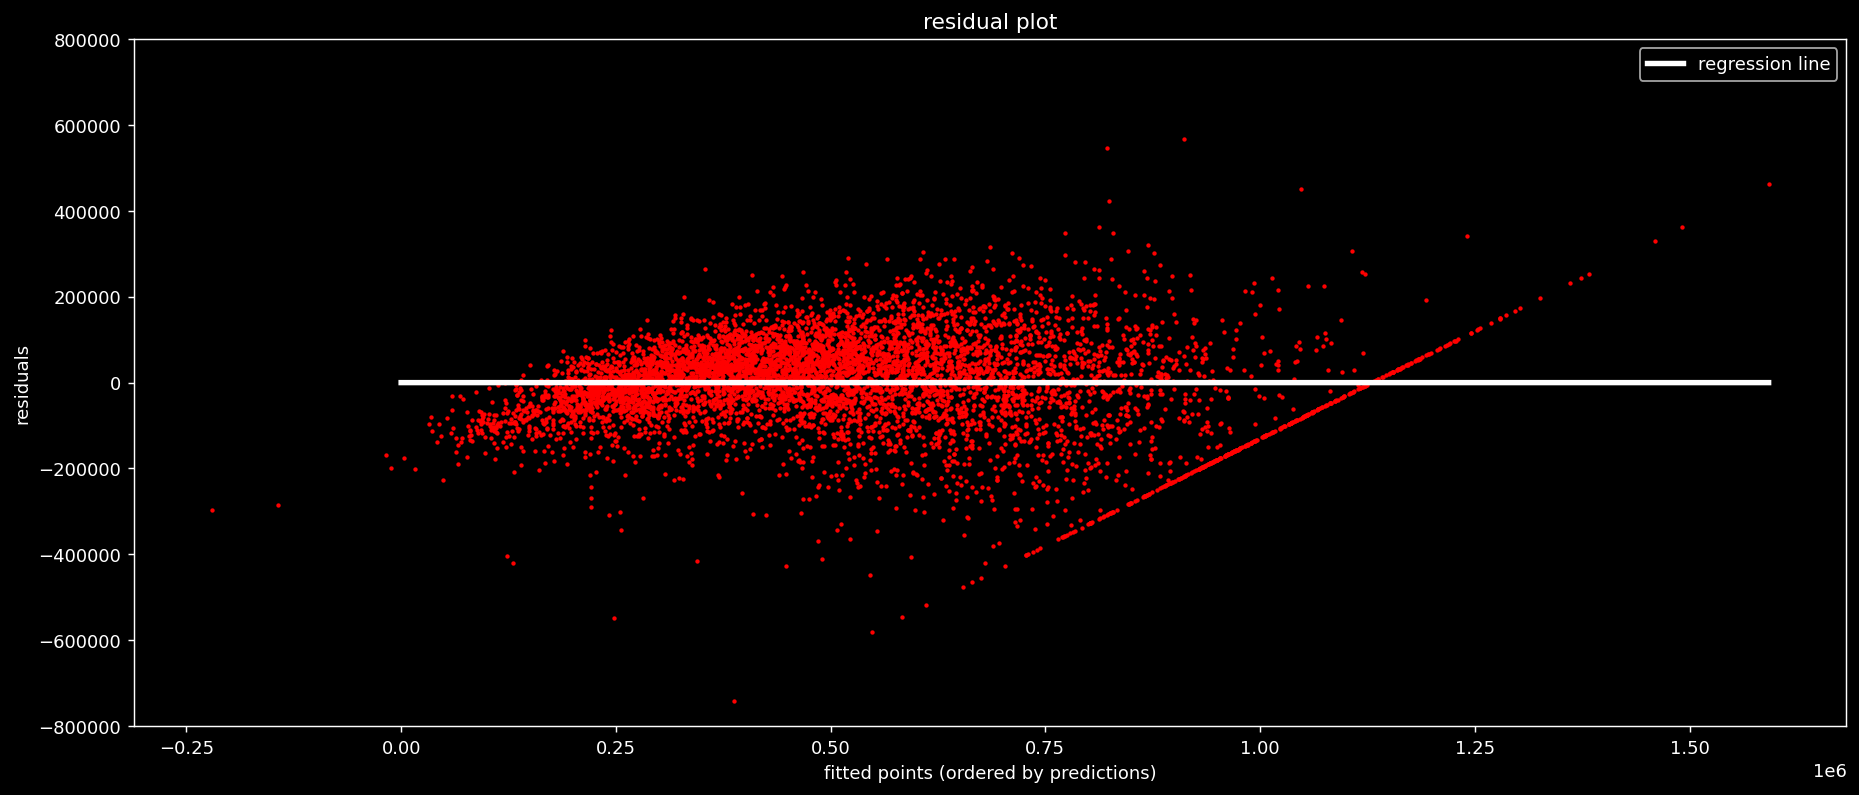

In [85]:
plt.figure(dpi = 130, figsize = (17,7))

plt.scatter( residual_table['predictions'], residual_table['residuals'], color = 'red', s = 2)
plt.plot(z, k, color = 'white', linewidth = 3, label = 'regression line')
plt.ylim(-800000, 800000)
plt.xlabel('fitted points (ordered by predictions)')
plt.ylabel('residuals')
plt.title('residual plot')
plt.legend()
plt.show()

# Inferences:-
# we can see that most of the residuals are densely populated between the limits 200000 and -200000
# so there is a good probability that the residuals are normally distributed
# the residual plot neither resembles the cone shape neithder the pipe shape
# so there is some scope of improvements in data
# there are some outliers with positive magnitude

## 2. Distribution of errors

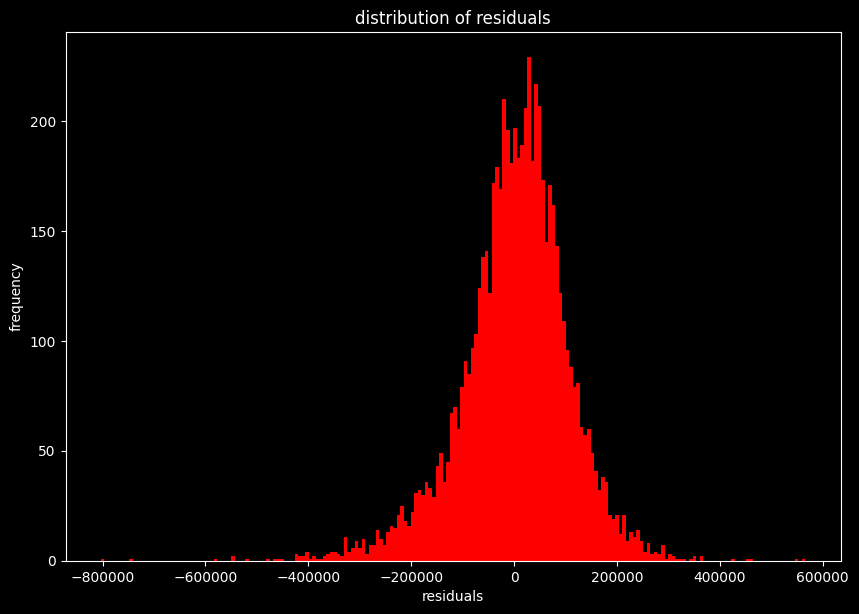

In [86]:
plt.figure(dpi = 100, figsize = (10,7))
plt.hist(residual_table['residuals'], color = 'red', bins = 200)
plt.xlabel('residuals')
plt.ylabel('frequency')
plt.title('distribution of residuals')
plt.show()

## Model Coefficients

In [87]:
coefficients_table = pd.DataFrame({'column': x_train.columns,
                                  'coefficients': lr.coef_})
coefficient_table = coefficients_table.sort_values(by = 'coefficients')


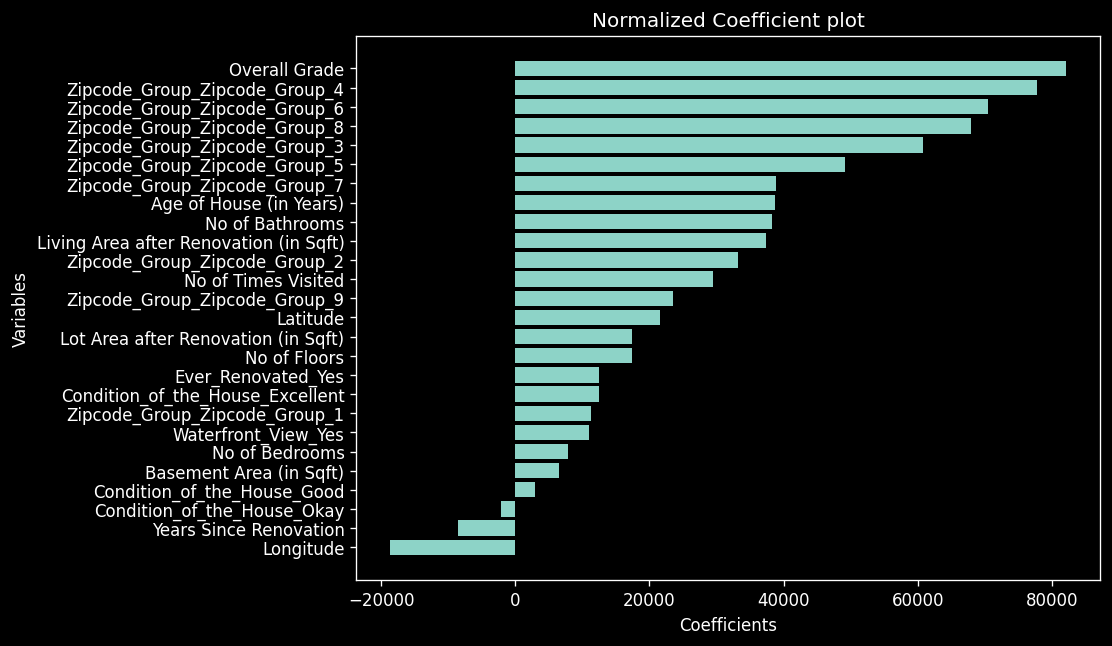

In [88]:
plt.figure(figsize=(8, 6), dpi=120)
x = coefficient_table['column']
y = coefficient_table['coefficients']
plt.barh( x, y)
plt.xlabel( "Coefficients")
plt.ylabel('Variables')
plt.title('Normalized Coefficient plot')
plt.show()

In [89]:
# inferences from the model:-
# Overall Grade plays a significant role in sale Price prediction
# Secondly Zipcode_Group4 plays a significant role -- location plays a significant role in sale price of the house
# The area of the house from basement also plays a major role in sale price prediction
# overall grade plays a quite vital role too
# age of the house is somewhat a counter intuitive , as our model says the older house are more expensive than the newer ones
# which is new knowledge
# other variables also played a positive role
# Negative Significance features --> As the time from the last renovation of the house  increased , the price of the house is decreased
# longitude has significant negative influence
# latitude has positive significance
# The houses in North east region have relatively higher prices than other places